In [1]:
# Import 
import os
import time
import json
import datetime
import pandas as pd
import numpy as np

from pathlib import Path
from tyssue import Sheet
from tyssue.io import hdf5

from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics import units, effectors, model_factory
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
import matplotlib.pyplot as plt
%matplotlib inline

vispy  won't work


In [2]:
import sys
sys.path.append("..")

In [3]:
from peripodial.polarity import model
from peripodial.dynamics import EllipsoidLameGeometry as geom
from peripodial.toolbox import modify_some_initial_settings


In [4]:
SIM_DIR = Path('/home/lglepin/Simulations/')
today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}_YolkElasticity'

try:
    sim_save_dir.mkdir(parents=True, exist_ok=True)
except FileExistsError:
    pass

In [5]:
!pwd

/home/lglepin/peripodial/notebook


In [6]:


dsets = hdf5.load_datasets('../json_hdf5/super_eggs_polarity.hdf5',
                               data_names=['vert', 'edge', 'face'])

with open('../json_hdf5/super_eggs_polarity.json', 'r+') as fp:
    specs = json.load(fp)

sheet = Sheet('spherical', dsets)

sheet.update_specs(specs)
modify_some_initial_settings(sheet)
geom.scale(sheet, 1 / sheet.face_df.area.mean()**0.5, list("xyz"))
geom.update_all(sheet)


In [7]:
specs['face'] = {"prefered_perimeter": 3.80}
sheet.update_specs(specs, reset=True)

In [8]:
sheet.face_df.area.mean()

1.0

In [9]:
sheet.face_df

,x,y,z,num_sides,area,perimeter,is_alive,face_o,opposite,height,...,area_elasticity,prefered_area,contractility,id,unique_id,apoptosis,current_traction,radial_tension,prefered_perimeter,perimeter_elasticity
face,,,,,,,,,,,,,,,,,,,,,
0,-0.933366,8.515433,-2.697284,7,1.103147,4.056634,1.0,0.0,-1.0,52.087582,...,1.0,1,0.05,0.0,0,0,0.0,0.0,3.8,10.0
1,-1.889968,8.419499,-2.324655,4,0.710065,3.488443,1.0,1.0,-1.0,52.020011,...,1.0,1,0.05,1.0,1,0,0.0,0.0,3.8,10.0
2,-2.672203,8.137965,-4.136637,6,1.080340,3.987939,1.0,2.0,-1.0,51.271449,...,1.0,1,0.05,2.0,2,0,0.0,0.0,3.8,10.0
3,3.434956,7.966767,-0.303690,6,1.164345,4.097696,1.0,3.0,-1.0,53.453223,...,1.0,1,0.05,3.0,3,0,0.0,0.0,3.8,10.0
4,-0.886647,8.622785,-0.299889,6,1.026347,3.881726,1.0,4.0,-1.0,52.352849,...,1.0,1,0.05,4.0,4,0,0.0,0.0,3.8,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,-2.290914,-5.601493,-13.122471,7,0.827213,3.808563,1.0,30.0,-1.0,34.400859,...,1.0,1,0.05,1647.0,1647,0,0.0,0.0,3.8,10.0
1648,8.367308,-1.601918,3.516173,6,1.098540,3.950032,1.0,89.0,-1.0,51.993019,...,1.0,1,0.05,1648.0,1648,0,0.0,0.0,3.8,10.0
1649,4.923755,6.077763,8.282794,7,1.135943,4.036410,1.0,153.0,-1.0,48.859431,...,1.0,1,0.05,1649.0,1649,0,0.0,0.0,3.8,10.0


In [10]:
sheet.settings["lumen_vol"]

5653.012070539491

In [11]:
specs

{'face': {'prefered_perimeter': 3.8},
 'settings': {'geometry': 'spherical',
  'height_axis': 'z',
  'lumen_prefered_vol': 5600,
  'lumen_vol_elasticity': 0.001,
  'threshold_length': 0.1,
  'rosette_kwargs': {'threshold_length': 0.01, 'p_4': 0.01, 'p_5': 0.001},
  'barrier_radius': 100}}

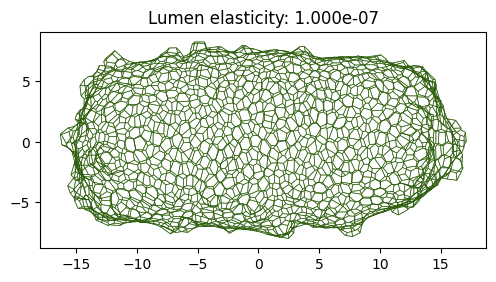

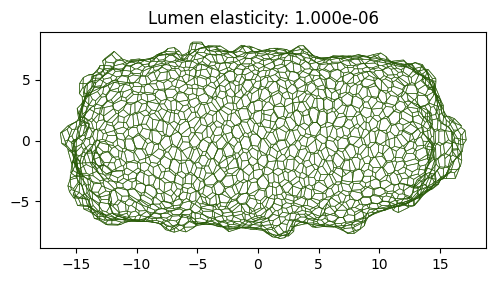

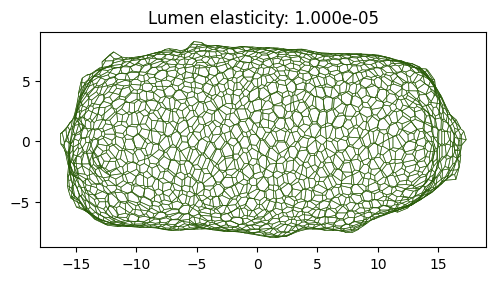

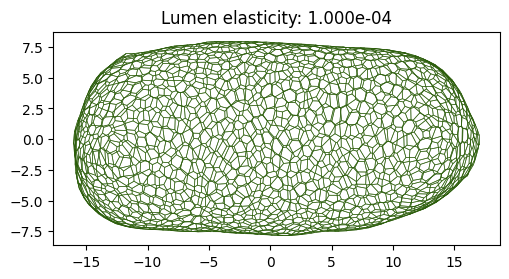

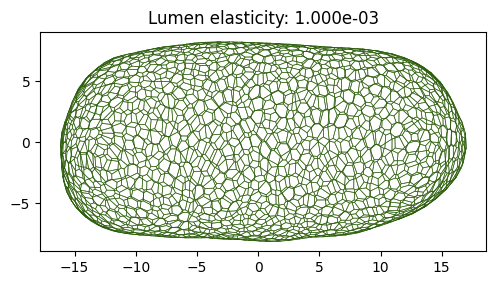

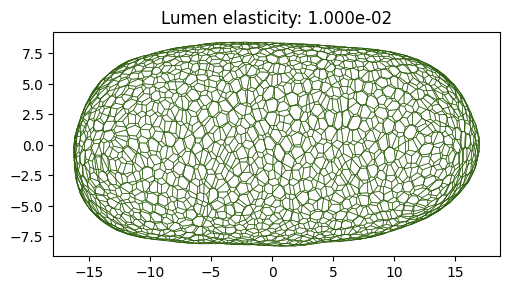

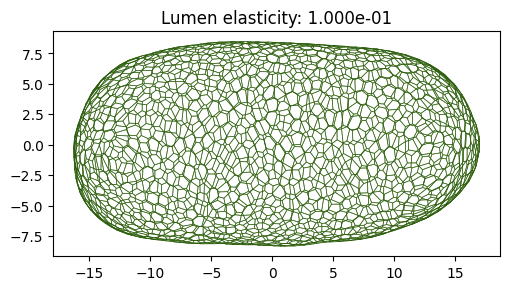

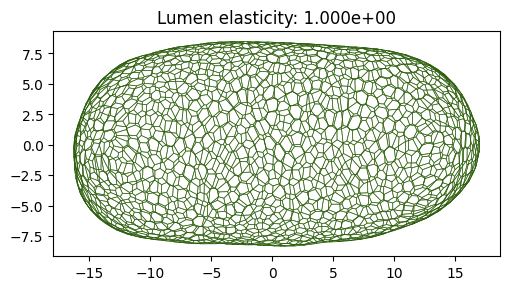

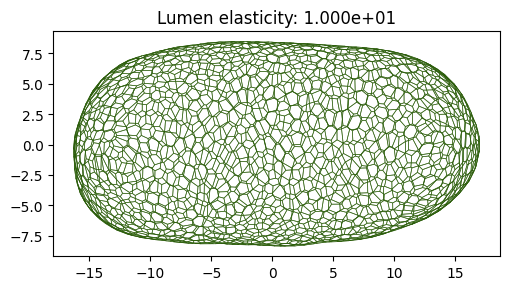

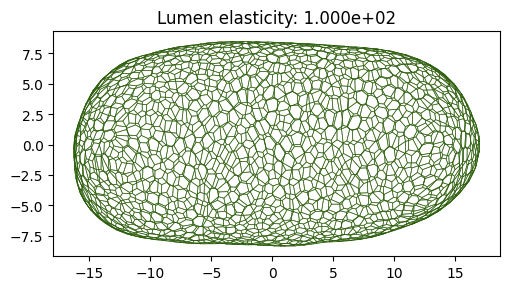

In [12]:
elasticity_values = []
lumen_volume_values = [] 
area_cell_mean = []
cell_perimeters_mean = []
diameters = []
areas_tot = []
perimeters_tot = []
sheet_copy = sheet.copy()

elasticity_values = np.logspace(-7, 2, 10)
for value in elasticity_values:
    sheet_copy.settings["lumen_vol_elasticity"] = value
    geom.update_all(sheet_copy)
    solver = QSSolver(with_t1=False, with_t3=False)
    res = solver.find_energy_min(sheet_copy, geom, model, options={"gtol": 1e-4})
    fig, ax = sheet_view(sheet_copy, coords=["z", "x"])
    lumen_volume = sheet_copy.settings["lumen_vol"]
    areas = sheet_copy.face_df["area"]
    area_cell = sheet_copy.face_df["area"].mean()
    ax.set_title(f"Lumen elasticity: {value:.3e}")
    lumen_volume_values.append(lumen_volume)
    length_max = np.percentile(sheet_copy.vert_df["z"], 99)
    length_min = np.percentile(sheet_copy.vert_df["z"], 1)
    diameter = length_max-length_min
    diameters.append(diameter)
    areas_tot.append(areas)
    area_cell_mean.append(area_cell)
    perimeters = sheet_copy.face_df["perimeter"]
    cell_perimeter = sheet_copy.face_df["perimeter"].mean()
    perimeters_tot.append(perimeters)
    cell_perimeters_mean.append(cell_perimeter)

lumen_volume_values = np.array(lumen_volume_values)
area_cell_values = np.array(area_cell_mean)

In [13]:
elasticity_values

array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02])

In [14]:
sheet_copy.face_df.area.mean()

1.0049366536652327

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


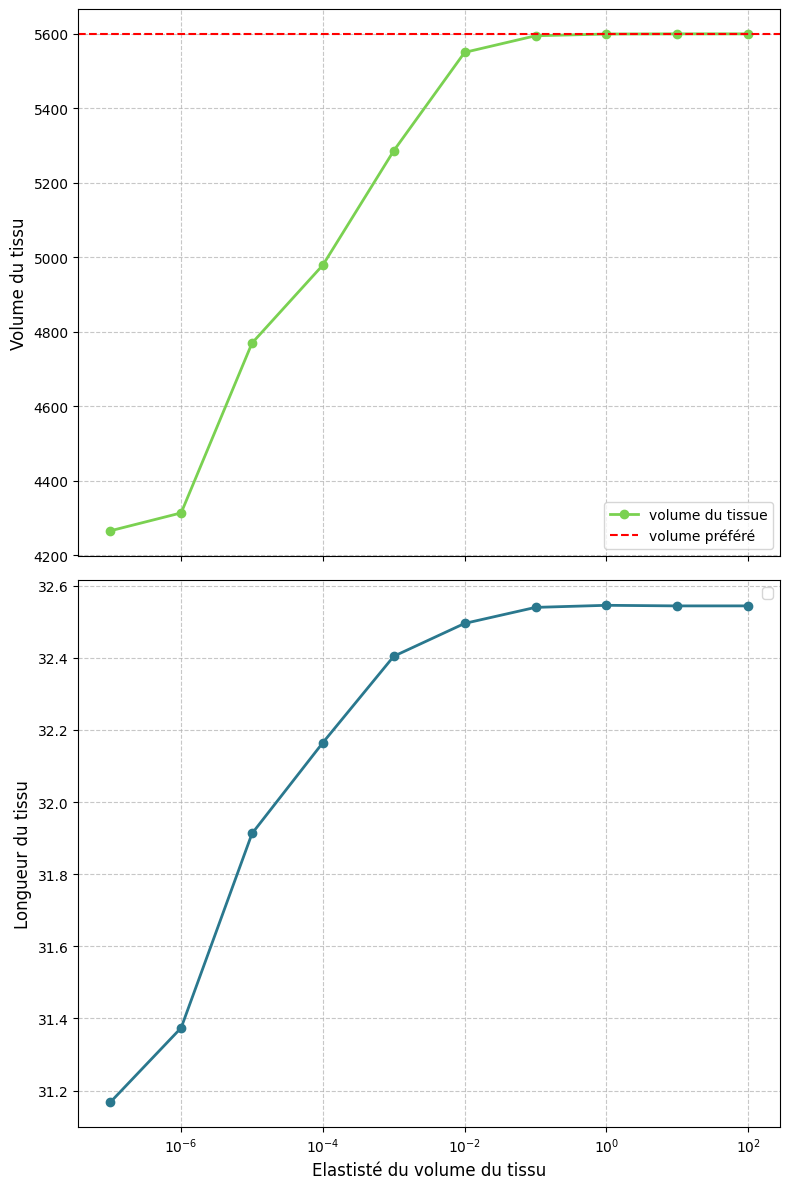

In [15]:
import matplotlib.pyplot as plt
import numpy as np

colors = plt.cm.viridis_r([0.2, 0.6])

# Create the plot with shared x-axis
fig, axs = plt.subplots(2, 1, figsize=(8, 12), sharex=True)

# Plot lumen_volume_values
axs[0].plot(elasticity_values, lumen_volume_values, label='volume du tissue', color=colors[0], marker='o', linestyle='-', linewidth=2)
axs[0].axhline(y=5600, color='r', linestyle='--', label='volume préféré')
# Set x-axis to logarithmic scale
axs[0].set_xscale('log')

# Set labels for x and y axes for the first plot
axs[0].set_ylabel('Volume du tissu', fontsize=12)

# Add a grid for better readability
axs[0].grid(True, linestyle='--', alpha=0.7)

# Set the legend for the first plot
axs[0].legend(loc='best', fontsize=10)

# Plot diameters
axs[1].plot(elasticity_values, diameters, color=colors[1], marker='o', linestyle='-', linewidth=2)
# Set x-axis to logarithmic scale
axs[1].set_xscale('log')

# Set labels for x and y axes for the second plot
axs[1].set_xlabel('Elastisté du volume du tissu', fontsize=12)
axs[1].set_ylabel('Longueur du tissu', fontsize=12)

# Add a grid for better readability
axs[1].grid(True, linestyle='--', alpha=0.7)

# Set the legend for the second plot
axs[1].legend(loc='best', fontsize=10)

# Tight layout to prevent overlap of labels
plt.tight_layout()
plt.savefig('../image/lumen_elasticity_combined.png', transparent=True)
# Show the plot
plt.show()


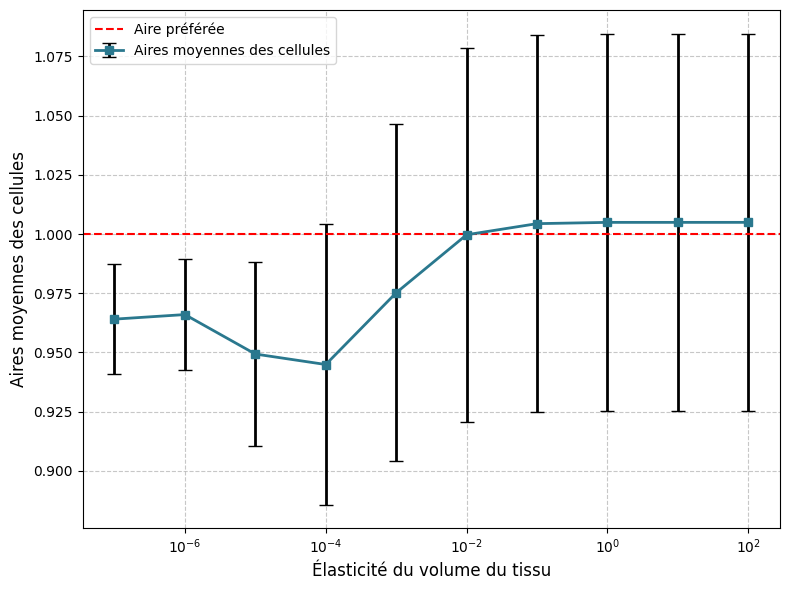

In [37]:
import matplotlib.pyplot as plt
import numpy as np

std_dev_values = [np.std(values) for values in areas_tot]

# Couleurs
colors = plt.cm.viridis_r([0.2, 0.6])

# Création de la figure et des axes
fig, axs = plt.subplots(1, figsize=(8, 6))

# Tracé des données avec les barres d'erreur
axs.errorbar(elasticity_values, area_cell_mean, yerr=std_dev_values, label='Aires moyennes des cellules', 
             color=colors[1], marker='s', linestyle='-', linewidth=2, capsize=5, ecolor='black')

# Ligne horizontale
plt.axhline(y=1.00, color='r', linestyle='--', label='Aire préférée')

# Échelle logarithmique pour l'axe des x
axs.set_xscale('log')

# Étiquettes des axes
axs.set_xlabel('Élasticité du volume du tissu', fontsize=12)
axs.set_ylabel('Aires moyennes des cellules', fontsize=12)

# Grille
axs.grid(True, linestyle='--', alpha=0.7)

# Légende
axs.legend(loc='best', fontsize=10)

# Ajustement de la mise en page
plt.tight_layout()

# Sauvegarde de la figure
plt.savefig('../image/area_cell_elasticity_lumen.png', transparent=True)

# Affichage de la figure
plt.show()


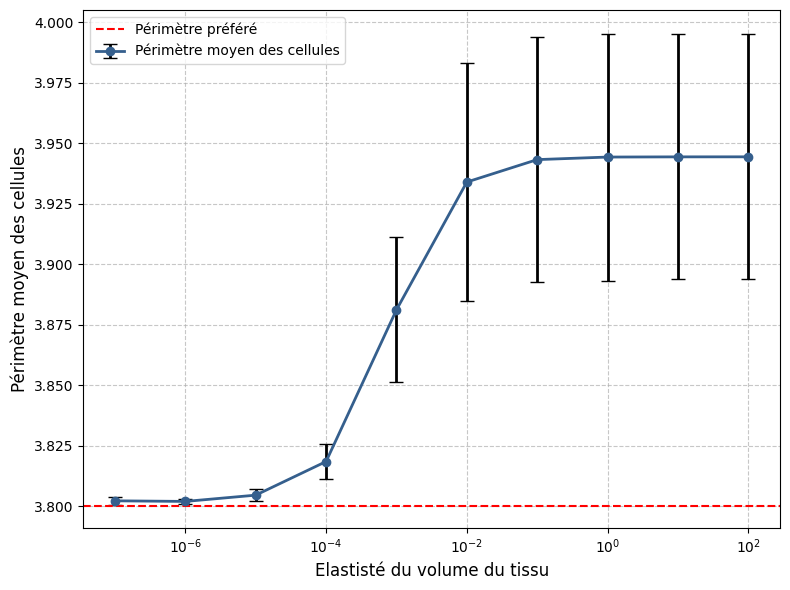

In [36]:
colors = plt.cm.viridis_r([0.7, 0.8])
peri_std_dev = [np.std(values) for values in perimeters_tot]
fig, axs = plt.subplots(1, figsize=(8, 6))
axs.errorbar(elasticity_values, cell_perimeters_mean, yerr=peri_std_dev, label='Périmètre moyen des cellules', color=colors[0], marker='o', linestyle='-', linewidth=2, capsize=5, ecolor='black')
plt.axhline(y=3.80, color='r', linestyle='--', label='Périmètre préféré')
axs.set_xscale('log')
axs.set_xlabel('Elastisté du volume du tissu', fontsize=12)
axs.set_ylabel('Périmètre moyen des cellules', fontsize=12)
axs.grid(True, linestyle='--', alpha=0.7)
axs.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.savefig('../image/cell_perimeters_elasticity_lumen.png', transparent=False)
plt.show()

In [ ]:
print (lumen_volume_values)

In [ ]:
specs

In [ ]:
specs = {'face': {'prefered_perimeter': 3.8},
 'settings': {'geometry': 'spherical',
  'height_axis': 'z',
  'lumen_prefered_vol': 5600,
  'lumen_vol_elasticity': 0.01,
  'threshold_length': 0.01,
  'rosette_kwargs': {'threshold_length': 0.01, 'p_4': 0.01, 'p_5': 0.001},
  'barrier_radius': 100},
 'vert': {'barrier_elasticity': 280}}

In [ ]:
sheet.update_specs(specs, reset=True)
solver = QSSolver(with_t1=False, with_t3=False)
res = solver.find_energy_min(sheet, geom, model, options={"gtol":1e-4})


In [ ]:
specs

In [ ]:
Sheet_ellips = sheet_view(sheet, coords=["z", "x"])

In [17]:
from tyssue.io.hdf5 import save_datasets
save_datasets("../json_hdf5/lumen_elasticity.hdf5", sheet)
from tyssue.config.json_parser import save_spec
save_spec(specs, "../json_hdf5/lumen_elasticity.json", overwrite=True)